In [1]:
from utils.configuration import get_config_from_json
from utils.training_utilities import set_GPU
from utils.plotting_traces import plot_traces
from seq2point.seq2point import SEQ2POINT
from dataset_management.dataloader import Seq2PointDataLoader
import builtins

In [2]:
builtins.MODEL_CONFIG = get_config_from_json(description="Model Parameters", config_file="configs/model_config.json")
builtins.DATASET_CONFIG = get_config_from_json(description="Dataset Management", config_file="configs/dataset_config.json")
builtins.PLOT_CONFIG = get_config_from_json(description="Plot Settings", config_file="configs/plot_config.json")
builtins.TRAINING_CONFIG = get_config_from_json(description="Training Configuration", config_file="configs/training_config.json")

In [3]:
TRAINING_CONFIG['EXPERIMENT_PATH'] = f'experiments/{TRAINING_CONFIG["TARGET_APPLIANCE"]}/{TRAINING_CONFIG["TARGET_HOUSES"]["TRAIN"]}/'

In [4]:
dataloaders = Seq2PointDataLoader()

Followings are the refit_loader configuration 
{'DATA_FOLDER': 'data/refit/', 'DATA_TYPE': '.csv', 'README_FILE': 'refit_loader/REFIT_Readme.txt', 'REFIT_HOUSES': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]}

Loading specified buildings: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]
Parsing the readme file specified: refit_loader/REFIT_Readme.txt
Loading data for appliance MICROWAVE ...
Fetching MICROWAVE data for House 2
Resampling for house number:  2
Updating data with resampled dataset...
Subetting dataset with 10 days of most activities for House 2
Estimating active durations of: microwave
Updating data with selected active appliance activities...
Updating splits with specified proportion from every target house...
Normalization is being performed for training a model. Scalers will be computed/fit considering the train_split and using those scalers, all splits will be normalized/transformed.
Updating splits with normalized data

In [5]:
network = SEQ2POINT().to(set_GPU())


Initializing SEQ2POINT model archiecture

Followings are the Model Parameters of your network architecture..
{'CONV_KERNEL': [10, 8, 6, 5, 5],
 'CONV_LAYERS': 5,
 'CONV_PADDING': 0,
 'CONV_STRIDE': 1,
 'DESCRIPTION': 'Model Parameters',
 'INPUT_CHANNELS': [1, 30, 30, 40, 50],
 'LEFT_PAD': [4, 3, 2, 2, 2],
 'LINEAR_INPUT': [29950, 1024],
 'LINEAR_LAYERS': 2,
 'LINEAR_OUTPUT': [1024, 1],
 'OUTPUT_CHANNELS': [30, 30, 40, 50, 50],
 'POOL_KERNEL': [],
 'POOL_STRIDE': [],
 'RIGHT_PAD': [5, 4, 3, 2, 2],
 'SEQUENCE_LENGTH': 599}

SEQ2POINT model archiecture has been initialized.



In [6]:
results = network.run(dataloaders.train_dataloader, dataloaders.validation_dataloader, assess_training=True)


Followings are the Training Configuration of your experiment..
{'DESCRIPTION': 'Training Configuration',
 'EARLY_STOPPING_THRESHOLD': 6,
 'EXPERIMENT_PATH': 'experiments/MICROWAVE/[2]/',
 'LEARNING_RATE': 0.0001,
 'LOSS': 'nn.MSELoss',
 'LOSS_REDUCTION': 'mean',
 'NORMALIZE': 'Standard',
 'NUM_EPOCHS': 12,
 'OPTIMIZER': 'optim.Adam',
 'PRE_TRAINED_MODEL_FLAG': False,
 'SPLIT_PROPORTION': {'TEST_PERCENT': 0.2,
                      'TRAIN_PERCENT': 0.6,
                      'VALIDATE_PERCENT': 0.2},
 'SUBSET_DAYS': 10,
 'TARGET_APPLIANCE': 'MICROWAVE',
 'TARGET_HOUSES': {'TEST': [2], 'TRAIN': [2], 'VALIDATE': [2]},
 'TEST_BATCH_SIZE': 1000,
 'THRESHOLD': 100.0,
 'TRAIN_BATCH_SIZE': 1000,
 'VALIDATION_BATCH_SIZE': 1000}

Summary of the model architecture
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 50, 599]             --
|    └─ConstantPad1d: 2-1                [-1, 1, 608]              --
|    └─Conv1d: 2-2  

Saving the Training Loss vs Validation Loss plot...



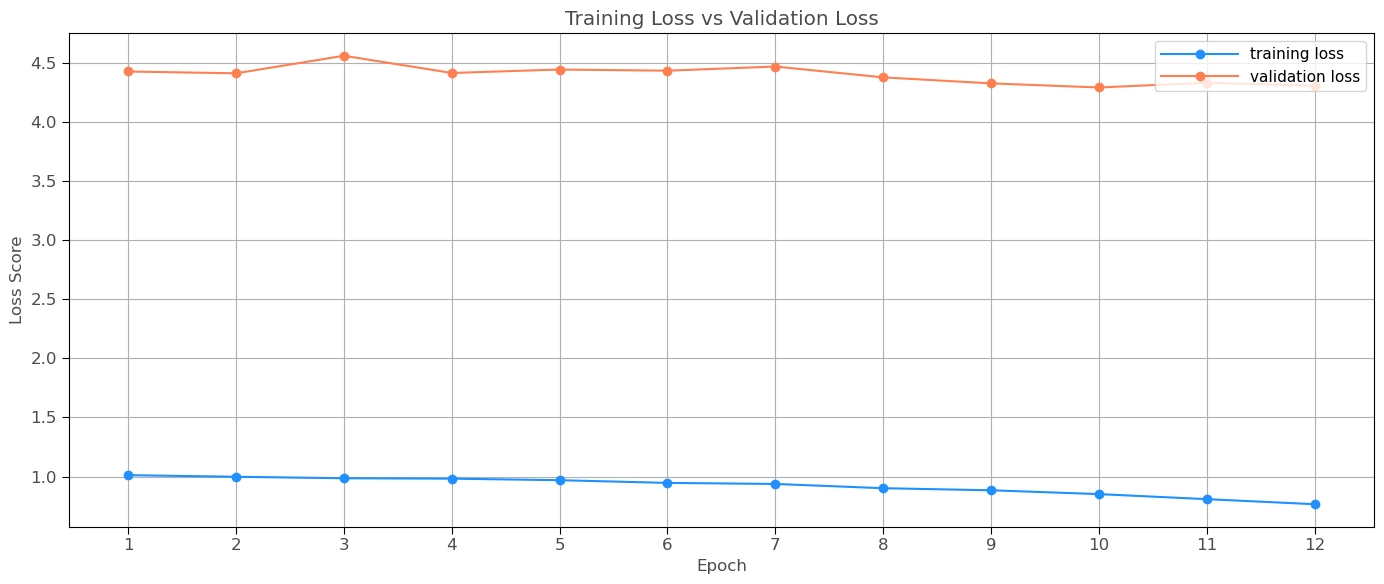

In [7]:
plot_traces(traces=[results[0], results[1]], labels = ['training loss', 'validation loss'], axis_labels=['Epoch', 'Loss Score'] , title="Training Loss vs Validation Loss")

Saving the Recall vs Precision per Epoch plot...



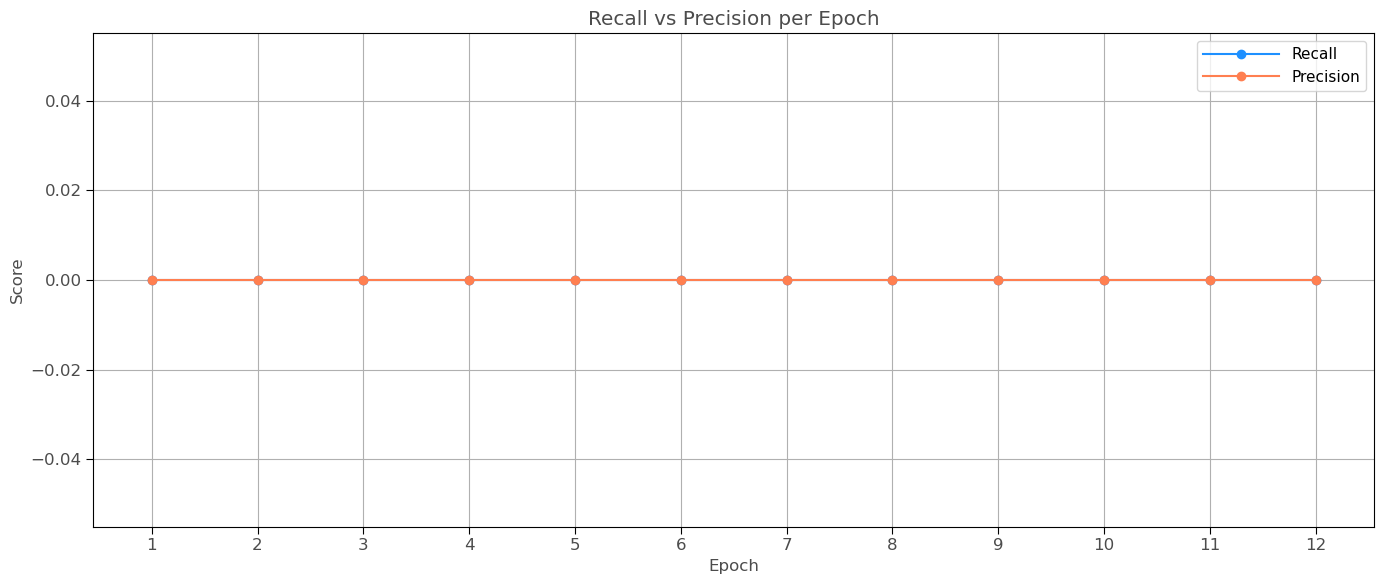

In [8]:
plot_traces(traces=[results[2], results[3]], labels = ['Recall', 'Precision'], axis_labels=['Epoch', 'Score'] , title="Recall vs Precision per Epoch")

In [9]:
test_network = SEQ2POINT().to(set_GPU())


Initializing SEQ2POINT model archiecture

Followings are the Model Parameters of your network architecture..
{'CONV_KERNEL': [10, 8, 6, 5, 5],
 'CONV_LAYERS': 5,
 'CONV_PADDING': 0,
 'CONV_STRIDE': 1,
 'DESCRIPTION': 'Model Parameters',
 'INPUT_CHANNELS': [1, 30, 30, 40, 50],
 'LEFT_PAD': [4, 3, 2, 2, 2],
 'LINEAR_INPUT': [29950, 1024],
 'LINEAR_LAYERS': 2,
 'LINEAR_OUTPUT': [1024, 1],
 'OUTPUT_CHANNELS': [30, 30, 40, 50, 50],
 'POOL_KERNEL': [],
 'POOL_STRIDE': [],
 'RIGHT_PAD': [5, 4, 3, 2, 2],
 'SEQUENCE_LENGTH': 599}

SEQ2POINT model archiecture has been initialized.



In [10]:
test_network.inference(dataloaders.test_dataloader)

Loading the model...experiments/MICROWAVE/[2]/models\2022-12-06_best_loss_4.pt
Model's state_dict:
conv.1.weight 	 torch.Size([30, 1, 10])
conv.1.bias 	 torch.Size([30])
conv.4.weight 	 torch.Size([30, 30, 8])
conv.4.bias 	 torch.Size([30])
conv.7.weight 	 torch.Size([40, 30, 6])
conv.7.bias 	 torch.Size([40])
conv.10.weight 	 torch.Size([50, 40, 5])
conv.10.bias 	 torch.Size([50])
conv.13.weight 	 torch.Size([50, 50, 5])
conv.13.bias 	 torch.Size([50])
dense.0.weight 	 torch.Size([1024, 29950])
dense.0.bias 	 torch.Size([1024])
dense.2.weight 	 torch.Size([1, 1024])
dense.2.bias 	 torch.Size([1])
Loss is set with loss_reduction = mean
Average Test Loss : 1.1207937193738127, Average Recall : 0.0, Average Precision : 0.0, Time consumption: 0:00:05.310587s


In [11]:
! pip install tensorboard
! tensorboard --logdir=runs --port=6006

^C
